# Fine-Tuning GPT-4.1 for Action Recognition in Video Clips
This Solution Accelerator demonstrates how to use Azure OpenAI GPT-4.1 vision fine-tuning to improve the model's performance in detecting human activities in video clips. The project utilizes the [UCF101 - Action Recognition](https://www.kaggle.com/datasets/matthewjansen/ucf101-action-recognition) dataset from Kaggle, a comprehensive video dataset featuring 101 distinct human action categories such as "playing guitar," "surfing," and "knitting." It contains 13,320 video clips, each labeled with a single action category.

Below are examples of video frames representing 8 of the 101 classes in the dataset:

<img src="frame-samples.png" alt="Frame Samples" width="1000">

__Acknowledgements:__

- Dataset: https://www.crcv.ucf.edu/research/data-sets/ucf101/
- Citation: https://arxiv.org/abs/1212.0402

This Solution Accelerator provides reusable code to help you apply vision fine-tuning for video analysis in various use cases.

> **Note:** By default, the Fine-Tuning API rejects images containing people and faces for AI safety reasons.
You can apply to opt out of this limitation by submitting a request here: https://customervoice.microsoft.com/Pages/ResponsePage.aspx.
Make sure to select the Modified Content Filtering option for Inferencing and Fine Tuning in question 14.

__Content:__

1. Retrieve dataset and specify scope
2. Prepare dataset for fine-tuning
3. Configure and start fine-tuning job
4. Deploy fine-tuned model
5. Test inference
6. Base versus fine-tuned model evaluation

## Setup

In [1]:
import json
import os
from io import StringIO
from typing import Dict, List

import pandas as pd
import requests
from dotenv import load_dotenv, find_dotenv
from openai import AzureOpenAI
from sklearn.metrics import classification_report
from tqdm import tqdm
import kagglehub
from azure.identity import DefaultAzureCredential

%config InlineBackend.figure_format = 'retina'

from VideoFTTools import DatasetHelper, VideoExtractor, VideoAnalyzer, Evaluator
from VideoFTTools import upload_frame_to_blob_as_jpeg, date_sorted_df

In [20]:
# Load environment variables
if not load_dotenv(find_dotenv()):
    raise IOError("Error: .env file could not be loaded!")

# Initialize OpenAI client
client = AzureOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version="2024-10-21"
)

# Central variables
project_name, version = "action-recognition-ft", "dev-01"  # For naming files and models
ft_deployment = f"{project_name}-{version}"  # Deployment name for the fine-tuned model
base_deployment = "gpt-4.1"  # Base model deployment name (used for comparative evaluation)

# Dataset parameters
top_n_classes = 35  # Limit dataset to the top N most frequent classes (101 for full dataset)
train_samples = 3000  # Number of training samples (None for complete size)
val_samples = 600  # Number of validation samples (None for complete size)
test_samples = 600  # Number of testing samples (None for complete size)

# Video processing parameters
no_frames = 5  # Number of frames to extract per video

# Reproducibility
random_seed = 0  # Seed for reproducibility of random operations

# Azure Storage configuration, optional for uploading the frames to Azure Storage. Alternatively, frames will be base64-encoded and included in the JSONL dataset files directly.
container_name = "frames"  # Azure container name for storing video frames as JPEGs
connection_string = os.getenv("AZURE_STORAGE_CONNECTION_STRING")

# Deployment configuration for fine-tuned model, optional for code based deployment. Alternatively, use the Azure AI Foundry portal.
subscription_id = os.getenv("SUBSCRIPTION_ID")  # Azure subscription ID
resource_name = os.getenv("AOAI_RESOURCE")  # Azure OpenAI resource name
rg_name = os.getenv("RESOURCE_GROUP")  # Azure resource group name

# ANSI escape codes for bold formatting in console outputs
bold_start, bold_end = '\033[1m', '\033[0m'

## Retrieve dataset and specify scope

The dataset presents diverse viewpoints, scales, camera motions, and lighting conditions, making it a challenging resource for action recognition tasks. It includes five categories of 101 action classes:
- Human-Object Interaction
- Body-Motion Only
- Human-Human Interaction
- Playing Musical Instruments
- Sports

This dataset is widely used as a benchmark in computer vision for training and evaluating action recognition models.  
**Note**: Please make sure that your Kaggle credentials are provided in the `.env` file.

In [3]:
# Download latest version from Kaggle. 
dataset_path = kagglehub.dataset_download("matthewjansen/ucf101-action-recognition")

print("Path to dataset files:", dataset_path)
os.listdir(dataset_path)

Path to dataset files: /home/codespace/.cache/kagglehub/datasets/matthewjansen/ucf101-action-recognition/versions/4


['val', 'val.csv', 'train', 'train.csv', 'test.csv', 'test']

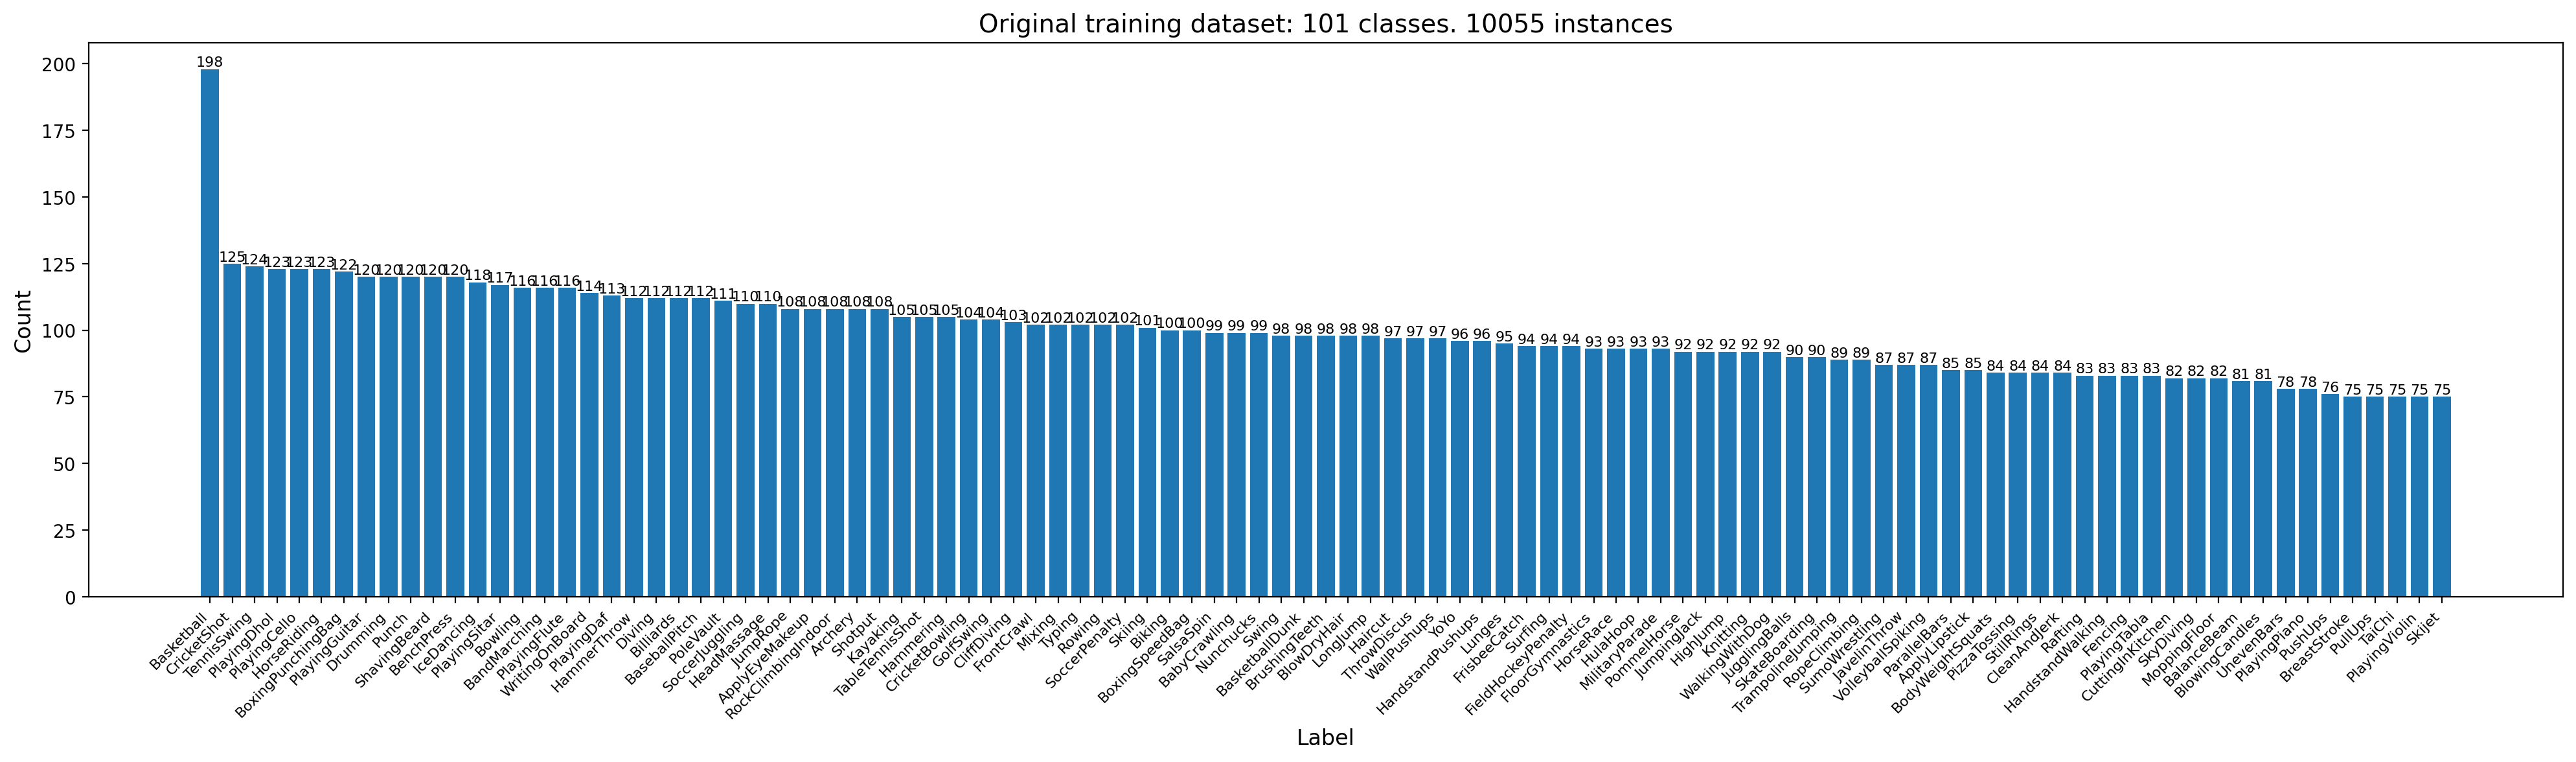

In [11]:
# retrieve local data
train_csv = os.path.join(dataset_path, "train.csv")
orig_train_df = pd.read_csv(train_csv)

val_csv = os.path.join(dataset_path, "val.csv")
orig_val_df = pd.read_csv(val_csv)

test_csv = os.path.join(dataset_path, "test.csv")
orig_test_df = pd.read_csv(test_csv)

# Remove leading slash if present. This step is specific to the action-recognition dataset
orig_train_df['clip_path'] = orig_train_df['clip_path'].str.lstrip('/')  
orig_val_df['clip_path'] = orig_val_df['clip_path'].str.lstrip('/')  
orig_test_df['clip_path'] = orig_test_df['clip_path'].str.lstrip('/')  

dataset_helper = DatasetHelper()
dataset_helper.plot_label_counts(orig_train_df, 'Original training dataset')

We are reducing the dataset complexity and size in two ways for quick development iterations:

1. Reduce number of dataset classes
2. Reduce train, val, and test splits to specified number of observations

Feel free to adjust the number of classes and instances for your own experiments.

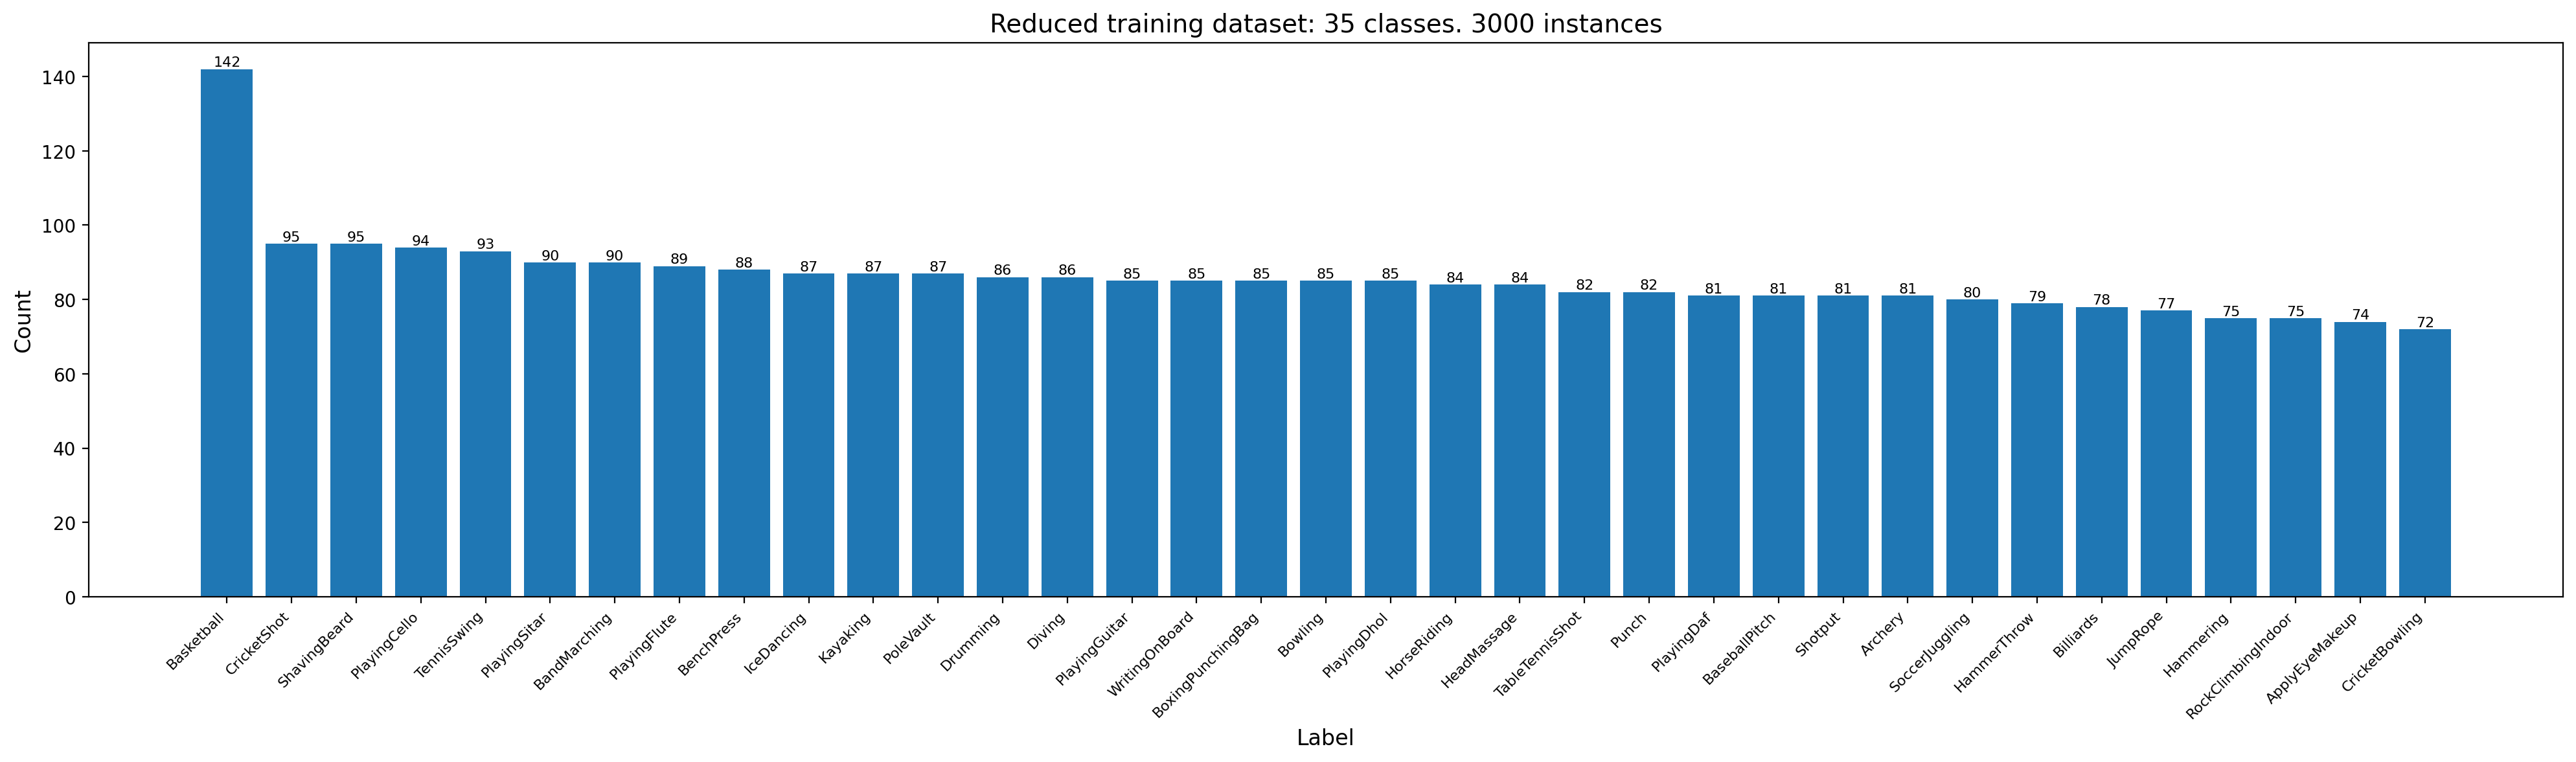

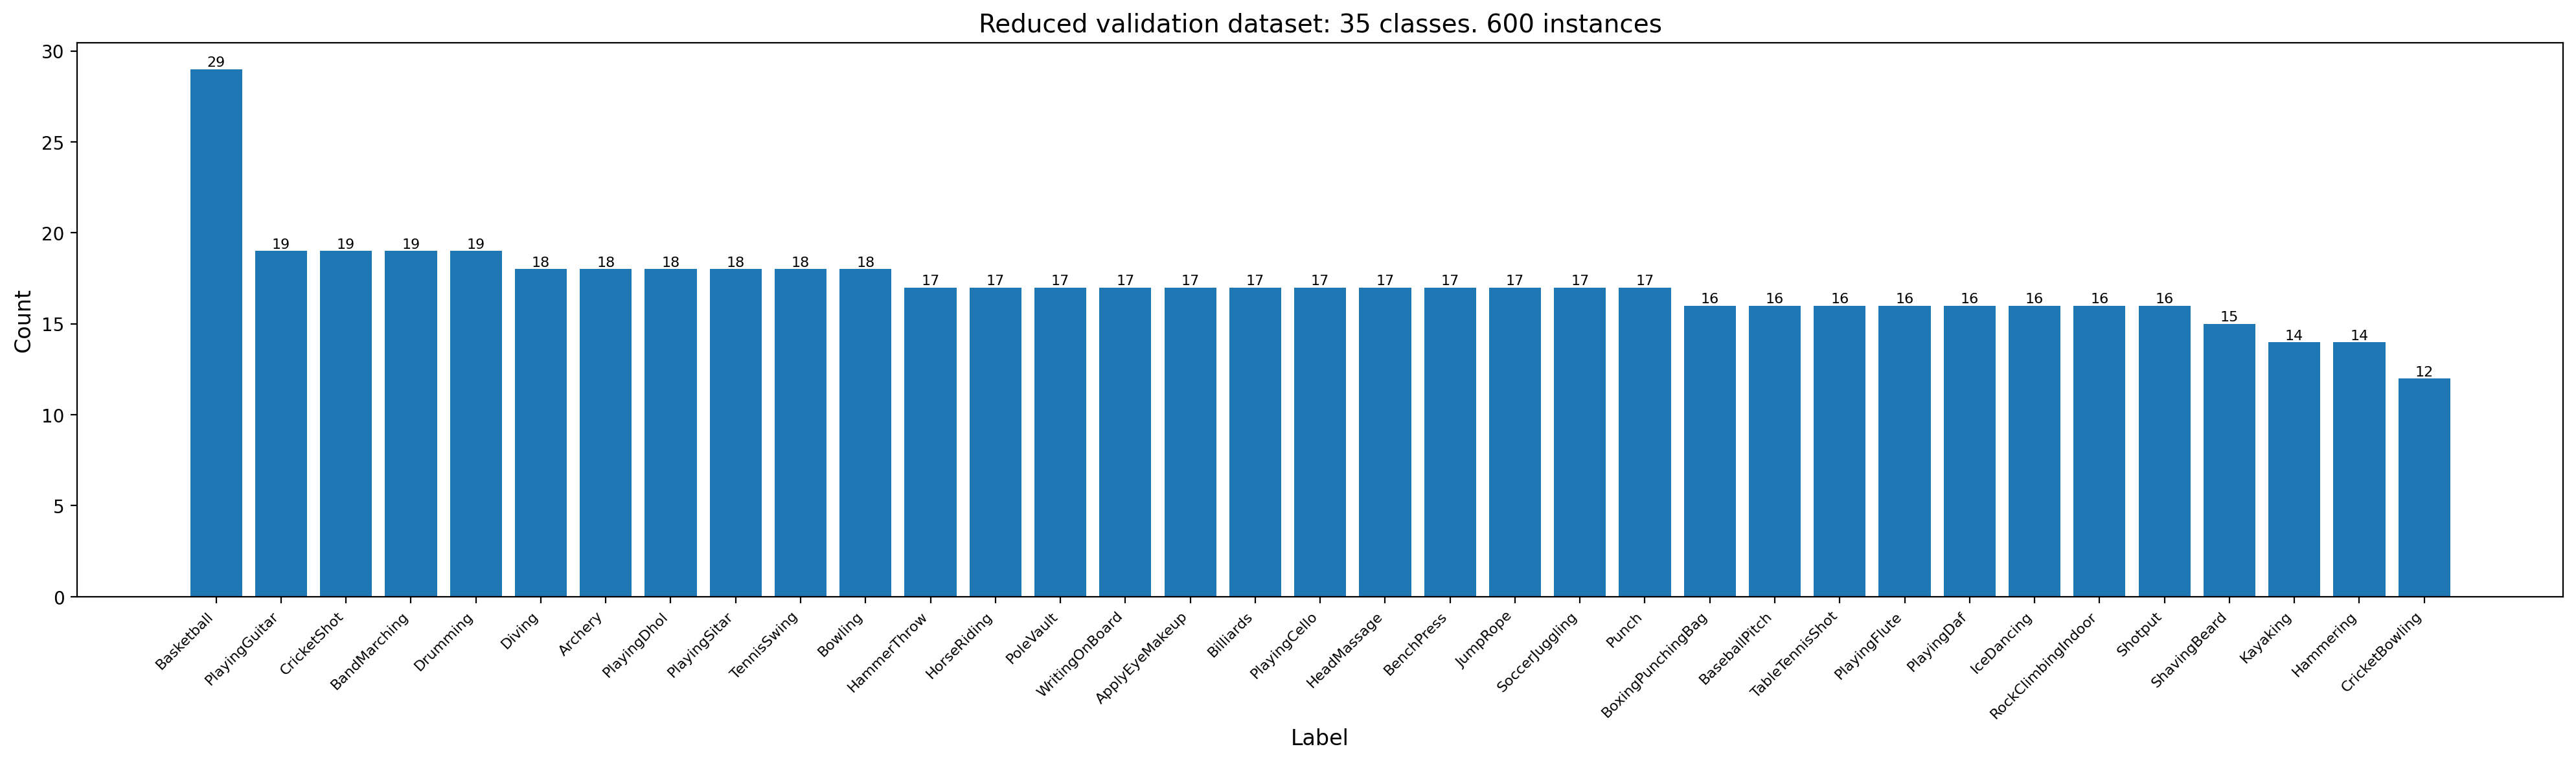

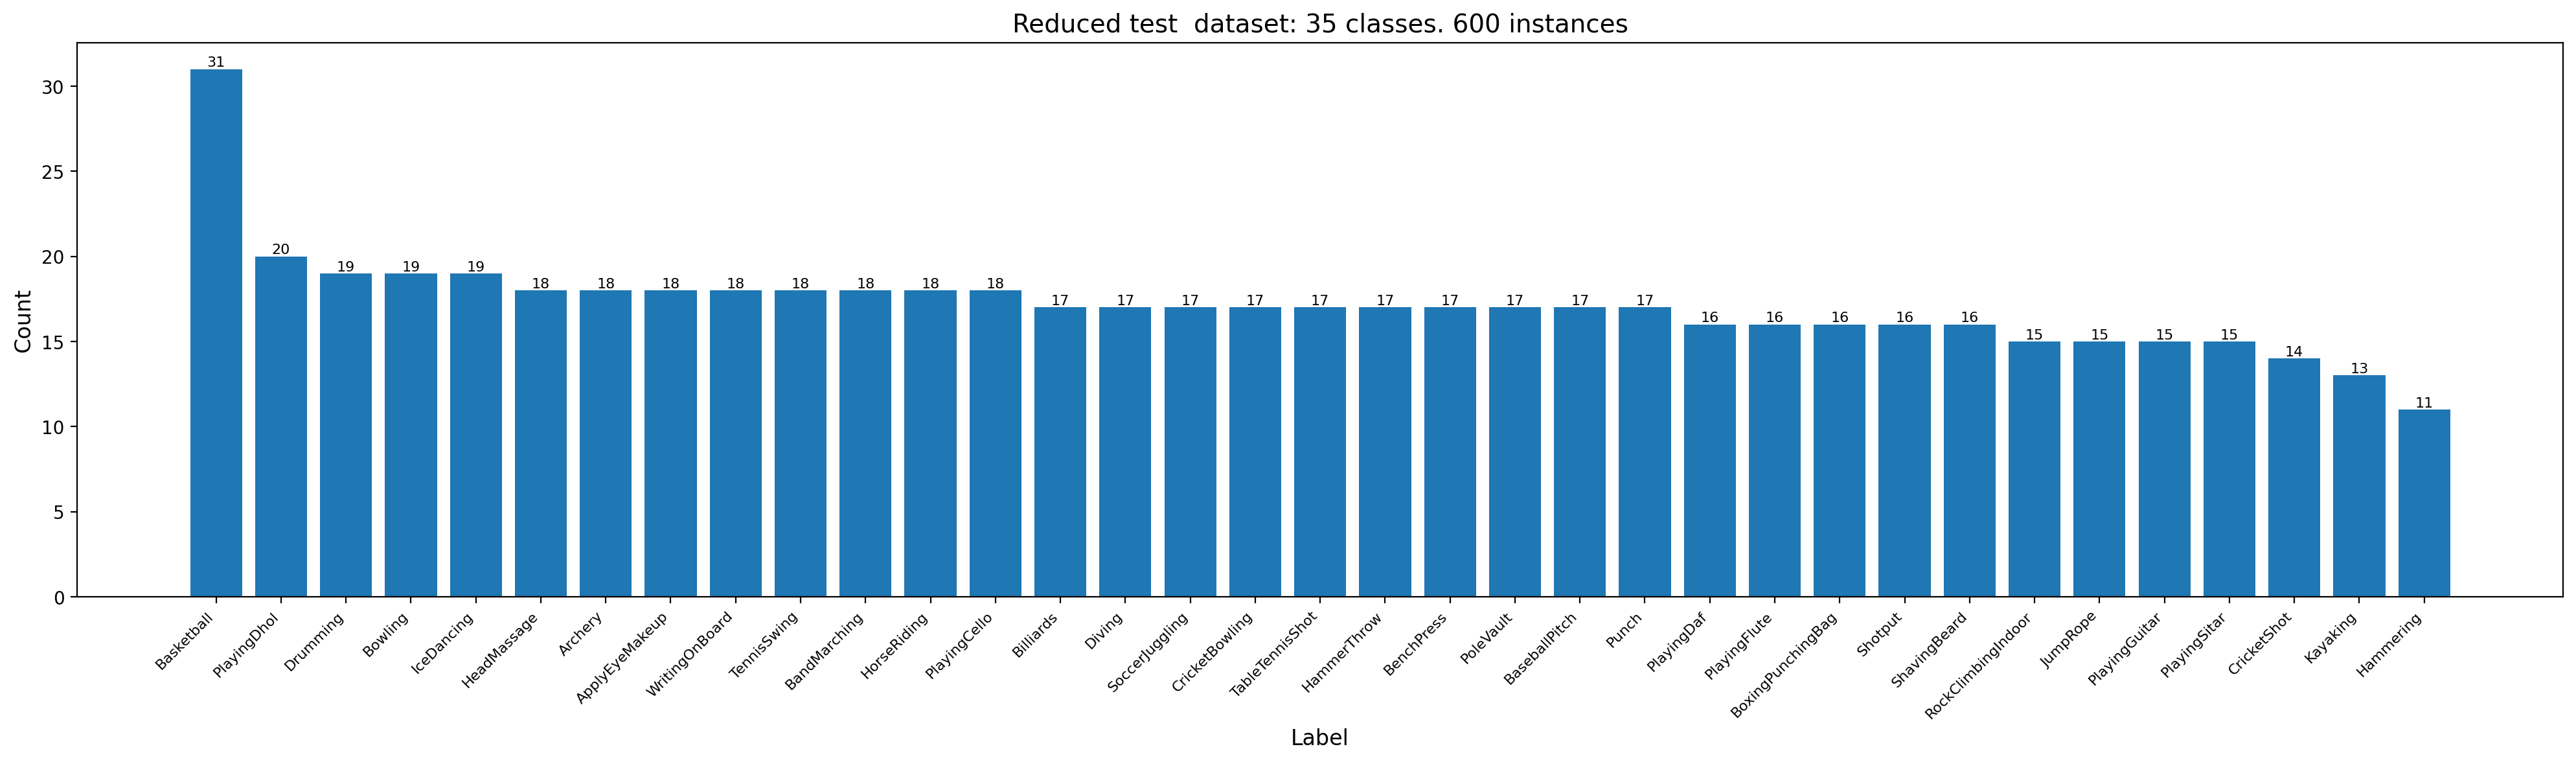

In [12]:
top_classes = orig_train_df['label'].value_counts().index[:top_n_classes]

train_df = orig_train_df[orig_train_df['label'].isin(top_classes)]
if train_samples:
    train_df = train_df.sample(n= train_samples, random_state= random_seed)

val_df = orig_val_df[orig_val_df['label'].isin(top_classes)]
if val_samples:
    val_df = val_df.sample(n= val_samples, random_state= random_seed)

test_df = orig_test_df[orig_test_df['label'].isin(top_classes)]
if test_samples:
    test_df = test_df.sample(n= test_samples, random_state= random_seed)

dataset_helper.plot_label_counts(train_df, 'Reduced training dataset')
dataset_helper.plot_label_counts(val_df, f'Reduced validation dataset')
dataset_helper.plot_label_counts(test_df, f'Reduced test  dataset')

## Prepare dataset for fine-tuning
Language models like GPT-4.1 are not capable of processing video files directly. Instead, we need to extract individual frames as images to send to the model. For instance, a short 20-second video recorded at 25 fps could contain up to 500 frames, making it computationally expensive to process all of them. To address this, we adopt a frame sampling strategy.

Frame sampling strategies reduce computational complexity and can be tailored to specific use cases. Common strategies include:

- **Sample at specified intervals**: Extract frames at regular intervals (e.g., every 0.25 seconds).
- **Sample a fixed number of frames**: Select a specified number of frames evenly distributed across the video duration.
- **Scene-based sampling**: Identify distinct scenes in the video and sample frames from each scene.
- **Drop similar frames**: Remove redundant frames that contain minimal variation.

These strategies can also be combined to meet more complex requirements.

To begin, we examine the durations of the videos in the training dataset using the `DatasetHelper.plot_video_duration_histogram()` method. This analysis provides insights into the distribution of video lengths, helping to inform our sampling approach.


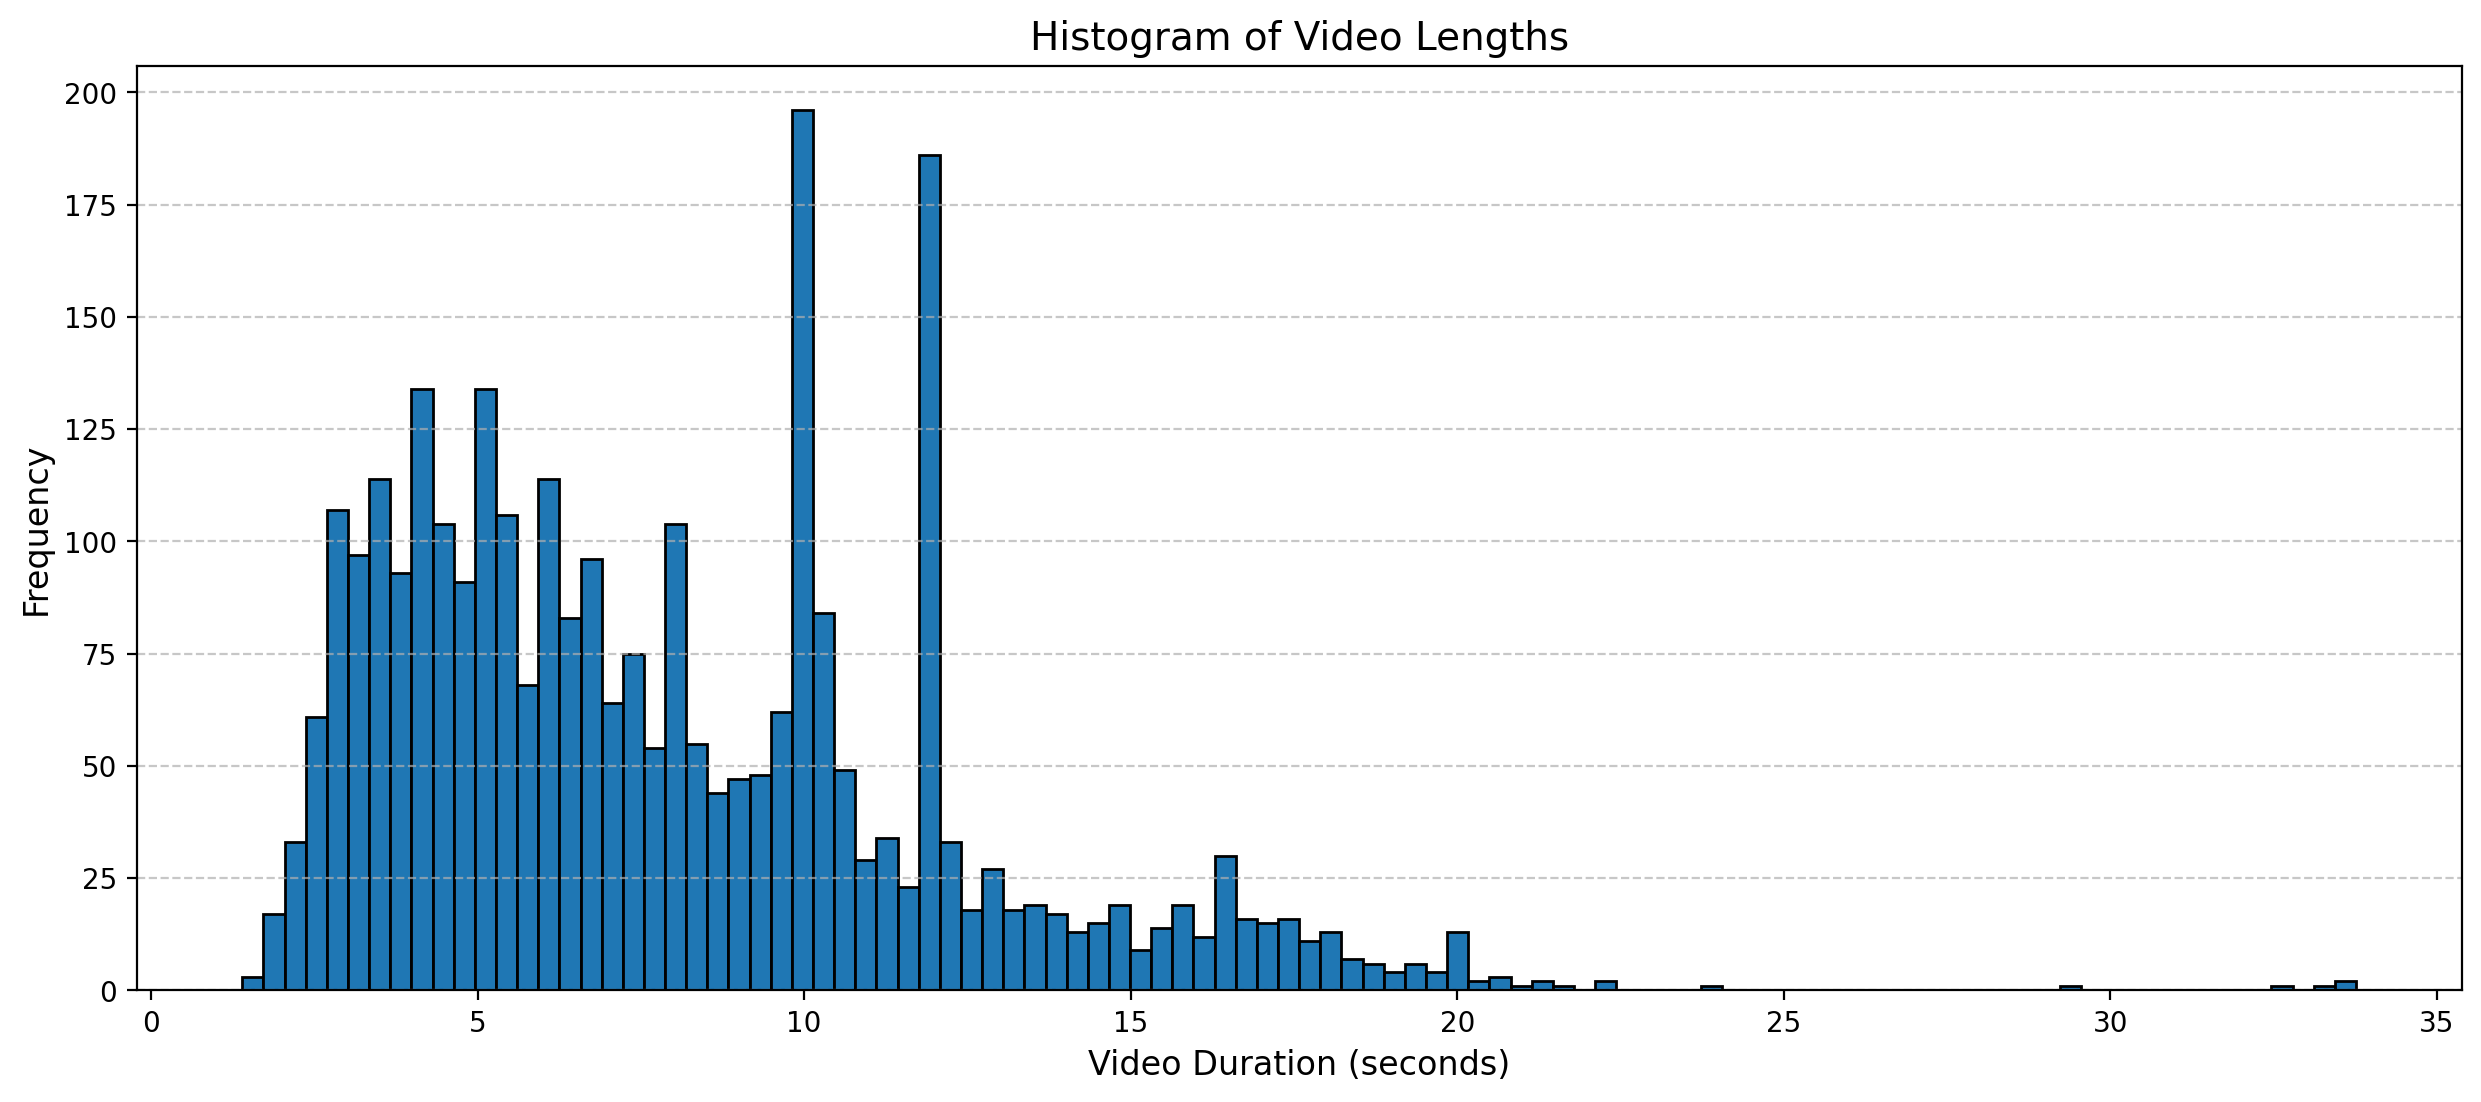

In [8]:
dataset_helper.plot_video_duration_histogram(train_df, dataset_path)


The `VideoExtractor.extract_n_video_frames(n)` method extracts `n` frames from a video file, distributing them evenly across the video's duration. Additionally, it appends a timestamp strip to each frame, providing the model with temporal context to understand the sequence and timing of events in the video.


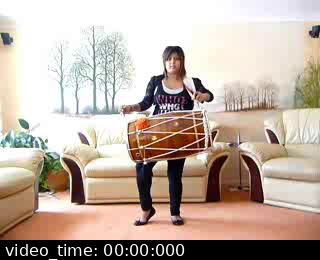
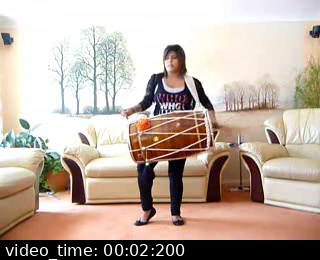
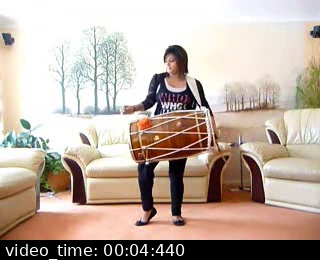
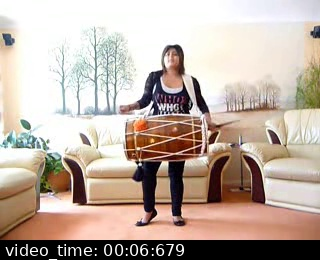
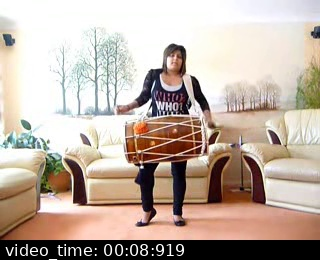

In [9]:
# pick a random video
video_path = os.path.join(dataset_path, train_df.sample(n=1)['clip_path'].iloc[0])

video_extractor = VideoExtractor(video_path)

frames = video_extractor.extract_n_video_frames(n=no_frames)
video_extractor.display_frames(frames, height=180)

Since the videos in our dataset are quite short and most of them consist of just one scene, we decide to sample only 5 frames per video.

Fine-tuning for video frames is possible with JSONL dataset files similar to the process of sending images as input to the chat completion API.
Images can be provided as HTTP URLs or data URLs containing base64-encoded images.

The next cells are for illustration purposes only (no need to execute).

_Example of video frames provided as **URLs**:_

In [ ]:
{
    "messages": [
        {
            "role": "system",
            "content": "You are an AI that identifies human activities in video frames. Use the provided frames to recognize one activity from this list: ['Basketball', 'CricketShot', 'TennisSwing', 'PlayingGuitar', 'ShavingBeard']. Respond with a JSON object: {\"activity\": \"Activity name\"}."
        },
        {
            "role": "user",
            "content": "These are the video frames for activity identification."
        },
        {
            "role": "user",
            "content": [
                {"type": "image_url", "image_url": {"url": "https://example.com/frames/shavingbeard/frame1.jpg"}},
                {"type": "image_url", "image_url": {"url": "https://example.com/frames/shavingbeard/frame2.jpg"}},
                {"type": "image_url", "image_url": {"url": "https://example.com/frames/shavingbeard/frame3.jpg"}}
            ]
        },
        {
            "role": "assistant",
            "content": "{\"activity\": \"ShavingBeard\"}"
        }
    ]
}

_Example of video frames provided as **base64 encoded images**:_

In [ ]:
{
    "messages": [
        {
            "role": "system",
            "content": "You are an AI that identifies human activities in video frames. Use the provided frames to recognize one activity from this list: ['Basketball', 'CricketShot', 'TennisSwing', 'PlayingGuitar', 'ShavingBeard']. Respond with a JSON object: {\"activity\": \"Activity name\"}."
        },
        {
            "role": "user",
            "content": "These are the video frames for activity identification."
        },
        {
            "role": "user",
            "content": [
                {"type": "image_base64", "image_data": "data:image/jpg;base64,/9j/4AAQ..."},
                {"type": "image_base64", "image_data": "data:image/jpg;base64,/9j/4AAQ..."},
                {"type": "image_base64", "image_data": "data:image/jpg;base64,/9j/4AAQ..."}
            ]
        },
        {
            "role": "assistant",
            "content": "{\"activity\": \"ShavingBeard\"}"
        }
    ]
}

In [ ]:
top_classes_str = ', '.join(top_classes)

system_message = f"""You are an expert in identifying human activities in video clips. 
You are provided with a series of extracted frames from a video. Each frame includes a timestamp in the lower-left corner, formatted as 'video_time: mm:ss:msec'. Use these timestamps to understand the sequence and context of the video.

Your task is to identify a single human activity depicted in the video frames. The identified activity must be one of the following:
{top_classes_str}

Provide the result as a valid JSON object in the exact format below:
{{
    "activity": "The identified activity from the provided list, spelled exactly as given." (string)
}}
"""

The below function generates local JSONL dataset files in the format required for GPT-4.1 vision fine-tuning. The files are uploaded to the Azure OpenAI Fine-tuning API later. Use the `image_source` parameter to specify how to provide the video frames:
- `base64`: Frames will be included in the JSONL file directly as base64-encoded strings. 
- `url`: Frames will be uploaded to an Azure Storage Blob container that you provide and an URL pointing to the video frames will be generated.

In [11]:
# defining the function here so that it can be adjusted to other dataset formats directly
def generate_ft_dataset(
    df, 
    frames_per_video: int = 5, 
    image_source: str = 'base64',
    dataset_path: str = dataset_path,
    system_message: str = system_message,
    container_name: str = container_name,
    connection_string: str = connection_string
) -> List[Dict]:
    """
    Generates a dataset from video clips by extracting frames and including their metadata.

    Args:
        df: A pandas DataFrame containing video metadata. Must include `clip_path` and `label` columns.
        frames_per_video (int): Number of frames to extract from each video. Default is 5.
        image_source (str): Specifies the source of the image data ('base64' or 'url').
        dataset_path (str): Path to the dataset containing video files. Default is './datasets'.
        system_message (str): A system message to initialize the dataset entry. Default is "Process video frames".
        container_name (str): Azure Blob Storage container name for uploading images. Default is "frames".
        connection_string (str): Azure Blob Storage connection string.

    Returns:
        List[Dict]: A list of dataset entries, each containing the frames and associated labels.

    Raises:
        ValueError: If `image_source` is not 'base64' or 'url'.
        RuntimeError: If frame extraction or Azure upload fails.
    """
    dataset = []

    for index, video in tqdm(df.iterrows(), total=df.shape[0], desc="Processing videos"):
        clip_path = video.get('clip_path')
        label = video.get('label')
        
        if not clip_path or not label:
            print(f"Skipping entry at index {index}: Missing 'clip_path' or 'label'")
            continue

        full_path = os.path.join(dataset_path, clip_path)

        # Extract video frames
        video_extractor = VideoExtractor(uri=full_path)
        try:
            frames = video_extractor.extract_n_video_frames(n=frames_per_video)
        except Exception as e:
            print(f"Failed to extract frames for video {clip_path}: {e}")
            continue

        # Initialize message
        message = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": "These are the frames from the video."}
        ]

        if image_source == 'base64':
            try:
                frames_list = [entry['frame_base64'] for entry in frames]
                message.append({"role": "user", "content": [
                    *map(lambda x: {"type": "image_url",
                                    "image_url": {"url": f'data:image/jpg;base64,{x}'}}, frames_list),
                ]})
            except KeyError:
                print(f"Missing 'frame_base64' key in frames for video {clip_path}")
                continue

        elif image_source == 'url':
            frame_urls = []
            for frame in frames:
                try:
                    video_name = os.path.splitext(os.path.basename(clip_path))[0]
                    timestamp_safe = frame['timestamp'].replace(':', '-')
                    blob_name = f"{clip_path}/{video_name}-{timestamp_safe}.jpg"

                    # Upload frame to Azure Blob Storage
                    blob_url = upload_frame_to_blob_as_jpeg(
                        base64_frame=frame['frame_base64'],
                        connection_string=connection_string,
                        container_name=container_name,
                        blob_name=blob_name
                    )
                    frame_urls.append({"type": "image_url", "image_url": {"url": blob_url}})
                except Exception as e:
                    print(f"Failed to upload frame for video {clip_path}: {e}")
                    continue

            message.append({"role": "user", "content": frame_urls})

        else:
            raise ValueError(f"Invalid image_source: {image_source}. Must be 'base64' or 'url'.")

        # Add assistant response with ground truth label
        message.append({"role": "assistant", "content": json.dumps({"activity": label})})

        dataset.append({"messages": message})

    return dataset

In [12]:
# generate training file
output_file_path = f"{project_name}-{version}-train.jsonl"
print(f"Creating dataset: {output_file_path}")

train_ds = generate_ft_dataset(train_df, image_source='base64')

with open(output_file_path, "w") as jsonl_file:
    for message in train_ds:
        jsonl_file.write(json.dumps(message) + "\n")

print(f"File size: {os.path.getsize(output_file_path) / (1024 * 1024):.2f} MB")

Creating dataset: gpt41-action-recognition-ft-dev-01-train.jsonl


Processing videos: 100%|██████████| 3000/3000 [01:48<00:00, 27.69it/s]


File size: 472.92 MB


In [13]:
# generate validation file
output_file_path = f"{project_name}-{version}-val.jsonl"
print(f"Creating dataset: {output_file_path}")

val_ds = generate_ft_dataset(val_df, image_source='base64')

with open(output_file_path, "w") as jsonl_file:
    for message in val_ds:
        jsonl_file.write(json.dumps(message) + "\n")

print(f"File size: {os.path.getsize(output_file_path) / (1024 * 1024):.2f} MB")

Creating dataset: gpt41-action-recognition-ft-dev-01-val.jsonl


Processing videos: 100%|██████████| 600/600 [00:22<00:00, 26.70it/s]


File size: 95.58 MB


## Configure and start fine-tuning job

In [14]:
# upload training file
train_file = client.files.create(
  file=open(f"{project_name}-{version}-train.jsonl", "rb"),
  purpose="fine-tune"
)

# upload validation file
val_file = client.files.create(
  file=open(f"{project_name}-{version}-val.jsonl", "rb"),
  purpose="fine-tune"
)

Here is some guidance if you want to adjust the hyperparameters of the fine-tuning process. You can keep them as `None` to use default values. 

| Hyperparameter                       | Description                                                                                                                                                                              |
|-----------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `Batch size`                            | The batch size to use for training. When set to default, batch_size is calculated as 0.2% of examples in training set and the max is 256.                                                           |
| `Learning rate multiplier` | The fine-tuning learning rate is the original learning rate used for pre-training multiplied by this multiplier. We recommend experimenting with values between 0.5 and 2. Empirically, we've found that larger learning rates often perform better with larger batch sizes. Must be between 0.0 and 5.0. |
| `Number of epochs`       | Number of training epochs. An epoch refers to one full cycle through the data set. If set to default, number of epochs will be determined dynamically based on the input data. |
| `Seed`  | The seed controls the reproducibility of the job. Passing in the same seed and job parameters should produce the same results, but may differ in rare cases. If a seed is not specified, one will be generated for you. |

In [15]:
# create fine tuning job
file_train = train_file.id
file_val = val_file.id

suffix = f"{project_name}-{version}"

ft_job = client.fine_tuning.jobs.create(
  suffix=suffix,
  training_file=file_train,
  validation_file=file_val, # optional
  model="gpt-4.1", # base model name or existing checkpoint (not the deployment name)
  seed=None,
  method={
      "type" : "supervised",
      "supervised" : {"hyperparameters" : {"n_epochs" : None,
                      "batch_size" : None,
                      "learning_rate_multiplier" : None,}
       }
  }
)

In [17]:
# List recent fine-tuning jobs
ft_jobs = client.fine_tuning.jobs.list(limit=5).to_dict()

display(date_sorted_df(pd.DataFrame(ft_jobs['data'])))

,id,created_at,hyperparameters,model,object,seed,status,training_file,validation_file,estimated_finish,suffix,fine_tuned_model,finished_at,result_files,trained_tokens
0,ftjob-70b83bfc4a2548b081bd3634f63f2503,2025-05-17 11:07:16,"{'batch_size': -1, 'learning_rate_multiplier':...",gpt-4.1-2025-04-14,fine_tuning.job,1914601644,pending,file-38cc193679c546fd8ee4856484d96653,file-baa37753783142228efa89824ceb38d6,1757498636,gpt41-action-recognition-ft-dev-01,NaN,NaN,NaN,NaN
1,ftjob-70ee3e37776e4428b20685fcd0728abb,2025-05-17 07:58:56,"{'batch_size': -1, 'learning_rate_multiplier':...",gpt-4.1-2025-04-14,fine_tuning.job,624499896,running,file-2290bb28ee454f0898f4684878eeef0a,file-7fe46f17557c4749a0498d3c92e9c2bc,1750059356,gpt41-chart-qa-dev-01,NaN,NaN,NaN,NaN
2,ftjob-699be2a60e2b4199a1ea5ffb3728bca4,2025-01-20 13:59:57,"{'batch_size': 4, 'learning_rate_multiplier': ...",gpt-4o-2024-08-06,fine_tuning.job,1100026964,succeeded,file-a5d6f97629144550bb811f9a4f30644e,file-0ff00d8748d04aa2a1d269ab329a6517,1737412530,action-recognition-ft-dev-02,gpt-4o-2024-08-06.ft-699be2a60e2b4199a1ea5ffb3...,2025-01-20 20:27:32,[file-bc4f373b512b405c8b9003baaa97988b],200217606.0
3,ftjob-78bf1165060b4e4ca98779d1ec1d12af,2025-01-19 09:37:08,"{'batch_size': 4, 'learning_rate_multiplier': ...",gpt-4o-2024-08-06,fine_tuning.job,1405305469,succeeded,file-be6d9587050547cd89a807122c40551d,file-de15a057b48442e2ba19f060e68dc343,1737299751,chart-qa-dev-01,gpt-4o-2024-08-06.ft-78bf1165060b4e4ca98779d1e...,2025-05-17 08:48:00,[file-e837572ba3804476a1f458fc3da92c37],129488088.0
4,ftjob-6c5eca7235d649b19ab70fbc7fced495,2025-01-18 12:38:05,"{'batch_size': 2, 'learning_rate_multiplier': ...",gpt-4o-2024-08-06,fine_tuning.job,1784294594,succeeded,file-e0e7d428df404149b093ca7caff7ef9a,file-fe1b860183e54045b8d7bf2a9ab8c290,1737210664,chart-qa-dev-01,gpt-4o-2024-08-06.ft-6c5eca7235d649b19ab70fbc7...,2025-01-20 13:37:13,[file-fbf6a6d971ef479ea074a09d292a9572],39198624.0


In [ ]:
# In case you want to retrieve a specific job 
# ft_job = client.fine_tuning.jobs.retrieve("ftjob-70b83bfc4a2548b081bd3634f63f2503")

In [4]:
display(ft_job.to_dict())

{'id': 'ftjob-70b83bfc4a2548b081bd3634f63f2503',
 'created_at': 1747480036,
 'fine_tuned_model': 'gpt-4.1-2025-04-14.ft-70b83bfc4a2548b081bd3634f63f2503-gpt41-action-recognition-ft-dev-01',
 'finished_at': 1747509260,
 'hyperparameters': {'batch_size': 6,
  'learning_rate_multiplier': 2.0,
  'n_epochs': 3},
 'model': 'gpt-4.1-2025-04-14',
 'object': 'fine_tuning.job',
 'result_files': ['file-082203657f1044e7ab4c99ddd4f919e8'],
 'seed': 1914601644,
 'status': 'succeeded',
 'trained_tokens': 371919891,
 'training_file': 'file-38cc193679c546fd8ee4856484d96653',
 'validation_file': 'file-baa37753783142228efa89824ceb38d6',
 'estimated_finish': 1754924765,
 'suffix': 'gpt41-action-recognition-ft-dev-01'}

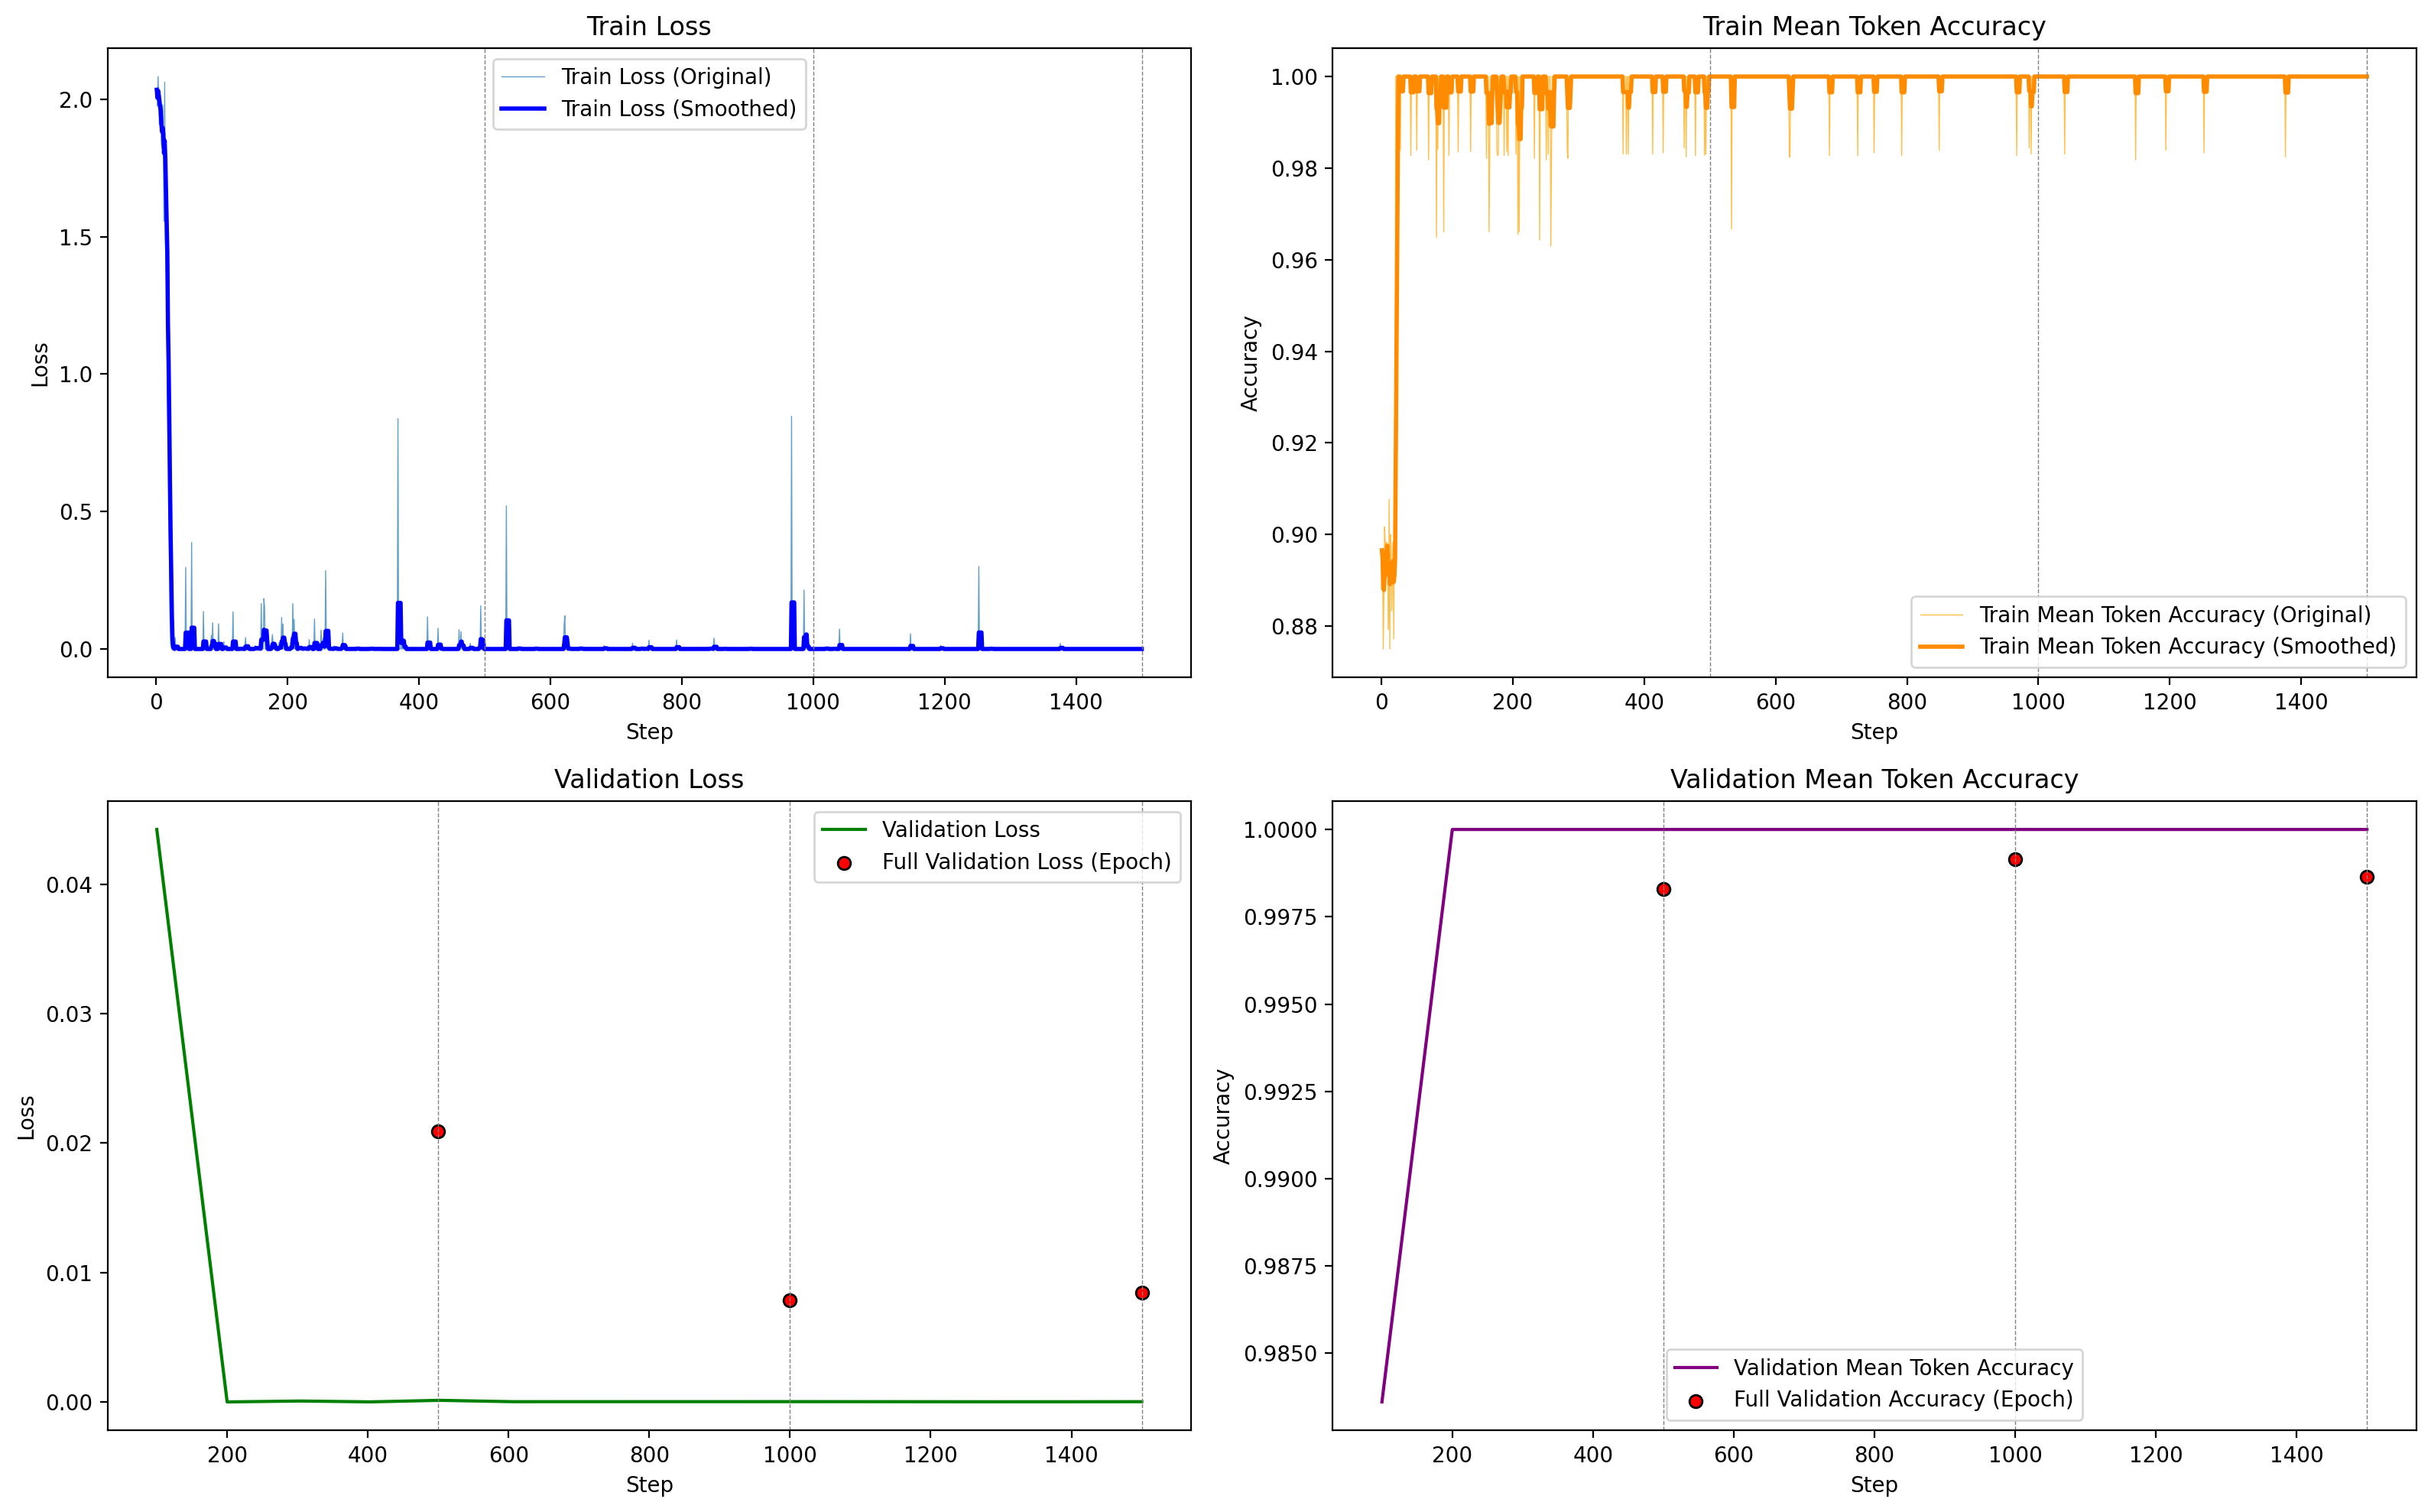

In [6]:
# Retrieve fine-tuning metrics from result file

result_file_id = ft_job.to_dict()['result_files'][0]
results_content = client.files.content(result_file_id).content.decode()

data_io = StringIO(results_content)

results_df = pd.read_csv(data_io)

evaluator = Evaluator()
evaluator.plot_learning_curves(results_df, smoothing_window=5)

Take a look at this table for an interpretation of above diagrams:  

| Metric                       | Description                                                                                                                                                                              |
|-----------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `step`                            | The number of the training step. A training step represents a single pass, forward and backward, on a batch of training data.                                                           |
| `train_loss`, `validation_loss` | The loss for the training / validation batch |
| `train_mean_token_accuracy`       | This metric represents the average accuracy of the model in predicting the correct token during the training phase. It is calculated by comparing the model's predicted tokens to the actual tokens in the training dataset. A higher value indicates better performance on the training data. For example, if the batch size is set to 3 and your data contains completions [[1, 2], [0, 5], [4, 2]], this value is set to 0.83 (5 of 6) if the model predicted [[1, 1], [0, 5], [4, 2]]. |
| `validation_mean_token_accuracy`  | This metric measures the average accuracy of the model in predicting the correct token on a separate validation dataset. It serves as an indicator of the model's ability to generalize to new, unseen data. Consistently low validation accuracy, especially when training accuracy is high, may suggest issues such as overfitting. |

## Deploy fine-tuned model
You can use the Azure AI Foundry portal to perform a manual deployment from your job under the __Fine-tuning__ menu.

If you prefer an automated  approach, the following code shows how to deploy the model using the Control Plane API. Take a look at the [Azure OpenAI fine-tuning documentation](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/fine-tuning?tabs=turbo&pivots=programming-language-python#deploy-fine-tuned-model) for more details.

In [18]:
# List existing models
my_models = client.models.list().to_dict()

models_df = date_sorted_df(my_models['data'])

cols = ['status', 'capabilities', 'lifecycle_status', 'id', 'created_at', 'model']
print(f'Models of AOAI resource {bold_start}{resource_name}{bold_end}:')
display(models_df[cols].head())

Models of AOAI resource aoai-ak-swece:


,status,capabilities,lifecycle_status,id,created_at,model
33,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",preview,gpt-4o-mini-transcribe-2025-03-20,2025-04-15 00:00:00,NaN
84,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",preview,gpt-4o-transcribe,2025-04-15 00:00:00,NaN
32,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",preview,gpt-4o-transcribe-2025-03-20,2025-04-15 00:00:00,NaN
85,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",preview,gpt-4o-mini-transcribe,2025-04-15 00:00:00,NaN
34,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",preview,gpt-4o-mini-tts-2025-03-20,2025-04-15 00:00:00,NaN


In [ ]:
fine_tuned_model = ft_job.to_dict()['fine_tuned_model'] # retrieve this value from the previous calls. Can also be a checkpoint name.

credential = DefaultAzureCredential()
token = credential.get_token("https://management.azure.com/.default").token

deploy_params = {'api-version': "2024-10-01"} 
deploy_headers = {'Authorization': 'Bearer {}'.format(token), 'Content-Type': 'application/json'}

deploy_data = {
    "sku": {"name": "GlobalStandard", "capacity": 100}, # in 1000 tokens per min
    "properties": {
        "model": {
            "format": "OpenAI",
            "name": fine_tuned_model, # retrieve this value from the previous calls. Can also be a specific checkpoint name.
            "version": "1"
        }
    }
}
deploy_data = json.dumps(deploy_data)

request_url = f'https://management.azure.com/subscriptions/{subscription_id}/resourceGroups/{rg_name}/providers/Microsoft.CognitiveServices/accounts/{resource_name}/deployments/{ft_deployment}' 

print('Creating a new deployment...')

r = requests.put(request_url, params=deploy_params, headers=deploy_headers, data=deploy_data)

print(r)
print(r.reason)
print(r.json())

## Test Inference

In [13]:
video_analyzer = VideoAnalyzer(client, ft_deployment)
display(test_df.head())

,clip_name,clip_path,label
1459,v_CricketShot_g17_c03,test/CricketShot/v_CricketShot_g17_c03.avi,CricketShot
535,v_PlayingDhol_g25_c01,test/PlayingDhol/v_PlayingDhol_g25_c01.avi,PlayingDhol
1455,v_CricketShot_g20_c02,test/CricketShot/v_CricketShot_g20_c02.avi,CricketShot
1716,v_Diving_g02_c05,test/Diving/v_Diving_g02_c05.avi,Diving
760,v_JumpRope_g22_c06,test/JumpRope/v_JumpRope_g22_c06.avi,JumpRope



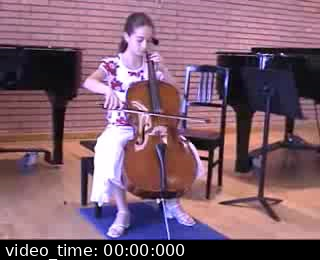
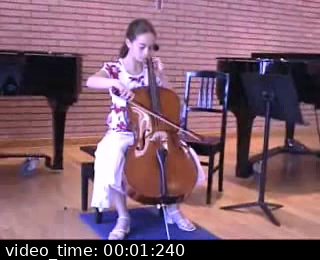
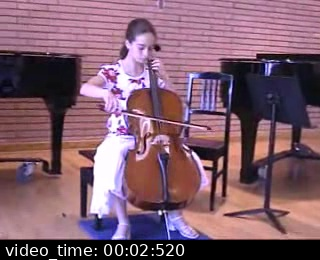
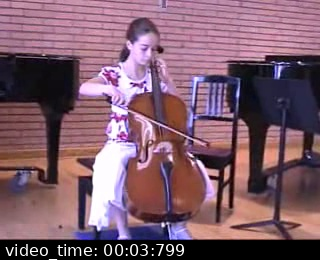
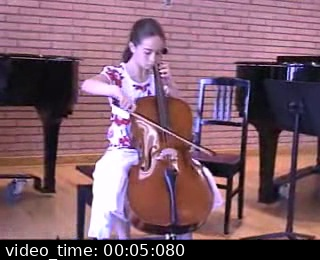

In [14]:
# pick a random video

sample = test_df.sample(n=1).iloc[0]
ground_truth_label = sample['label']
clip_path = sample['clip_path']

video_path = os.path.join(dataset_path, clip_path)

video_extractor = VideoExtractor(video_path)

frames = video_extractor.extract_n_video_frames(n=no_frames)
video_extractor.display_frames(frames, height=180)

In [50]:
frames_list = [entry['frame_base64'] for entry in frames]

llm_insights = video_analyzer.video_chat(frames_list, transcription=None, system_message=system_message)

print(f"Predicted activity: {llm_insights['activity']}")
print(f"Actual activity: {ground_truth_label}")

Predicted activity: PlayingCello
Actual activity: PlayingCello


## Base versus Fine-Tuned Model Evaluation

The following code can be used to systematically evaluate the base model (GPT-4.1 in this case) against the fine-tuned model on the test dataset. This comparison helps quantify the improvements achieved through fine-tuning.

In [21]:
def classify_video(clip_path, video_analyzer, local_path=None, frames_per_video=1):
    """ Classify a single video and return its predicted activity. """

    uri = os.path.join(local_path, clip_path) if local_path else clip_path
    video_extractor = VideoExtractor(uri)
    frames = video_extractor.extract_n_video_frames(n=frames_per_video)
    frames_list = [entry['frame_base64'] for entry in frames]
    llm_insights = video_analyzer.video_chat(frames_list, transcription=None, system_message=system_message)
    return llm_insights['activity']


def classify_videos_in_df(test_df, video_analyzer, local_path, frames_per_video, column_name):
    """ Classify videos in a DataFrame and add predictions to a specified column. """
    tqdm.pandas(desc=f"Processing {column_name}")
    test_df[column_name] = test_df.progress_apply(
        lambda row: classify_video(
            clip_path=row['clip_path'],
            video_analyzer=video_analyzer,
            local_path=local_path,
            frames_per_video=frames_per_video
        ), axis=1
    )
    return test_df

In [ ]:
# Base and fine-tuned model evaluation
base_video_analyzer = VideoAnalyzer(client, base_deployment)
ft_video_analyzer = VideoAnalyzer(client, ft_deployment)

# Classify with the base model
test_df = classify_videos_in_df(
    test_df=test_df,
    video_analyzer=base_video_analyzer,
    local_path=dataset_path,
    frames_per_video=no_frames,
    column_name='base_predicted_label'
)

# Classify with the fine-tuned model
test_df = classify_videos_in_df(
    test_df=test_df,
    video_analyzer=ft_video_analyzer,
    local_path=dataset_path,
    frames_per_video=no_frames,
    column_name='ft_predicted_label'
)

In [32]:
# save evaluation results
test_df.to_csv(f"{project_name}-{version}-eval-results-{test_df.shape[0]}-entries.csv", index=False)

In [38]:
# optionally reload previous evaluation
test_df = pd.read_csv("action-recognition-ft-dev-01-eval-results-600-entries.csv")
display(test_df.head())

,clip_name,clip_path,label,base_predicted_label,ft_predicted_label
0,v_CricketShot_g17_c03,test/CricketShot/v_CricketShot_g17_c03.avi,CricketShot,CricketShot,CricketShot
1,v_PlayingDhol_g25_c01,test/PlayingDhol/v_PlayingDhol_g25_c01.avi,PlayingDhol,PlayingDhol,PlayingDhol
2,v_CricketShot_g20_c02,test/CricketShot/v_CricketShot_g20_c02.avi,CricketShot,CricketShot,CricketShot
3,v_Diving_g02_c05,test/Diving/v_Diving_g02_c05.avi,Diving,Diving,Diving
4,v_JumpRope_g22_c06,test/JumpRope/v_JumpRope_g22_c06.avi,JumpRope,JumpRope,JumpRope


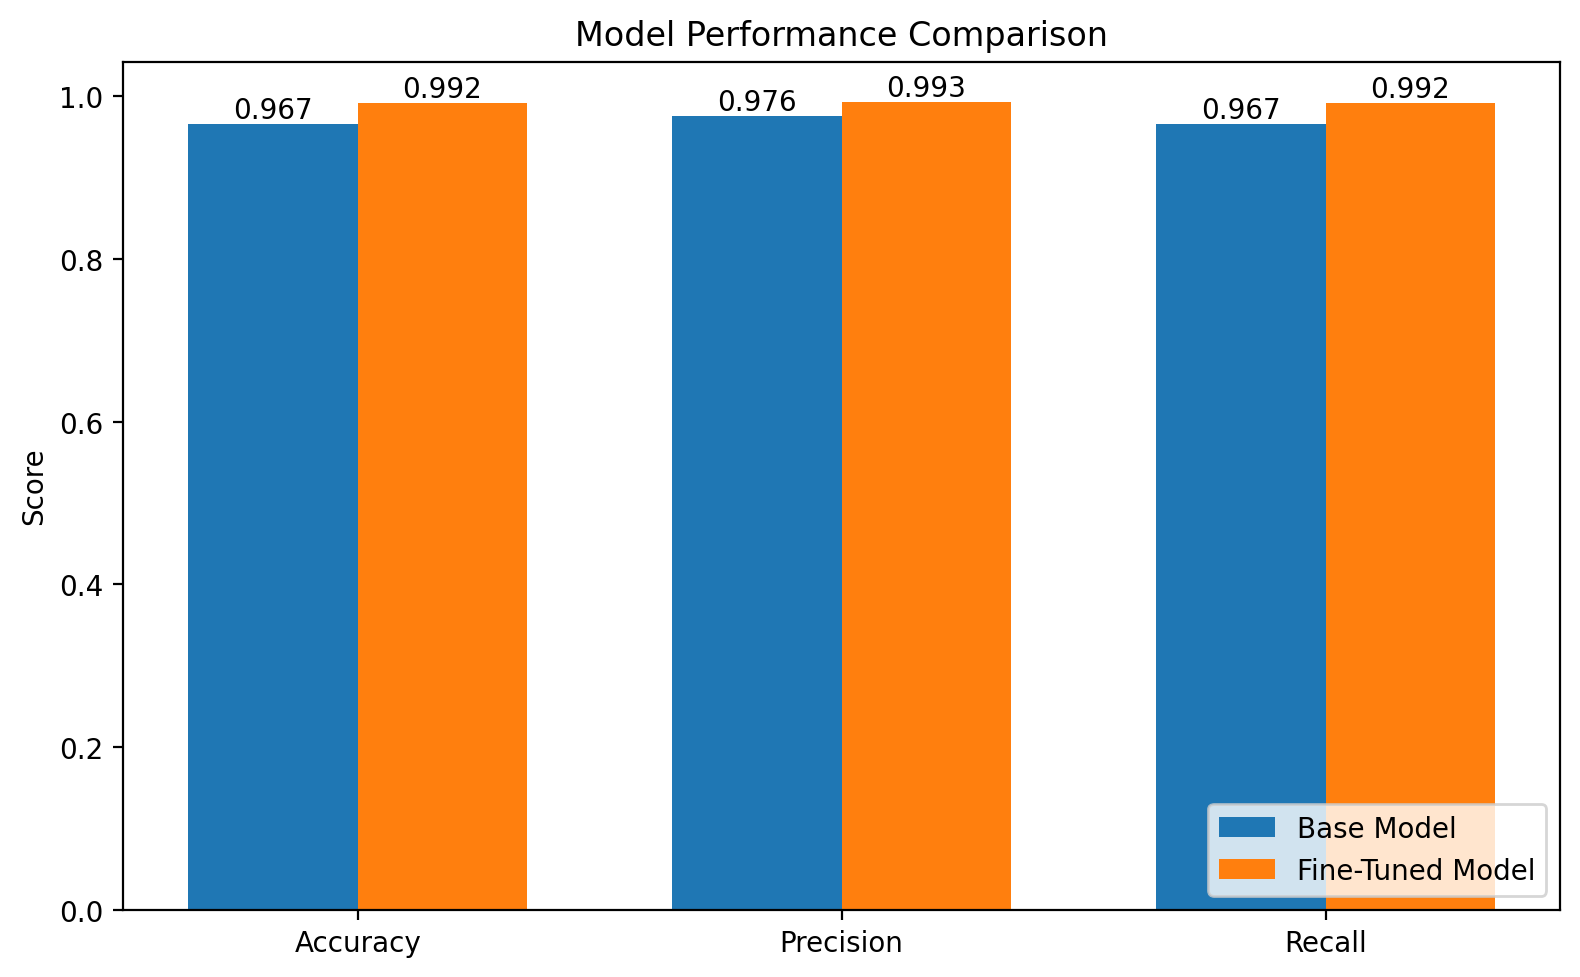

In [33]:
evaluator.compare_model_metrics(test_df)

After comparing the performance of the base vs. fine-tuned model, we can further analyze the fine-tuning results by inspecting the **classification report** and **confusion matrix**.

In [36]:
y_true = test_df['label']
y_pred = test_df['ft_predicted_label']

# Generate classification report
report = classification_report(y_true, y_pred, output_dict=False, zero_division=True)
print(report)

                    precision    recall  f1-score   support

    ApplyEyeMakeup       1.00      0.94      0.97        18
           Archery       1.00      1.00      1.00        18
      BandMarching       1.00      1.00      1.00        18
     BaseballPitch       1.00      1.00      1.00        17
        Basketball       1.00      1.00      1.00        31
        BenchPress       1.00      1.00      1.00        17
         Billiards       1.00      1.00      1.00        17
           Bowling       1.00      1.00      1.00        19
 BoxingPunchingBag       1.00      1.00      1.00        16
    CricketBowling       1.00      0.94      0.97        17
       CricketShot       1.00      1.00      1.00        14
            Diving       1.00      1.00      1.00        17
          Drumming       1.00      1.00      1.00        19
       HammerThrow       1.00      1.00      1.00        17
         Hammering       1.00      0.82      0.90        11
       HeadMassage       1.00      0.94

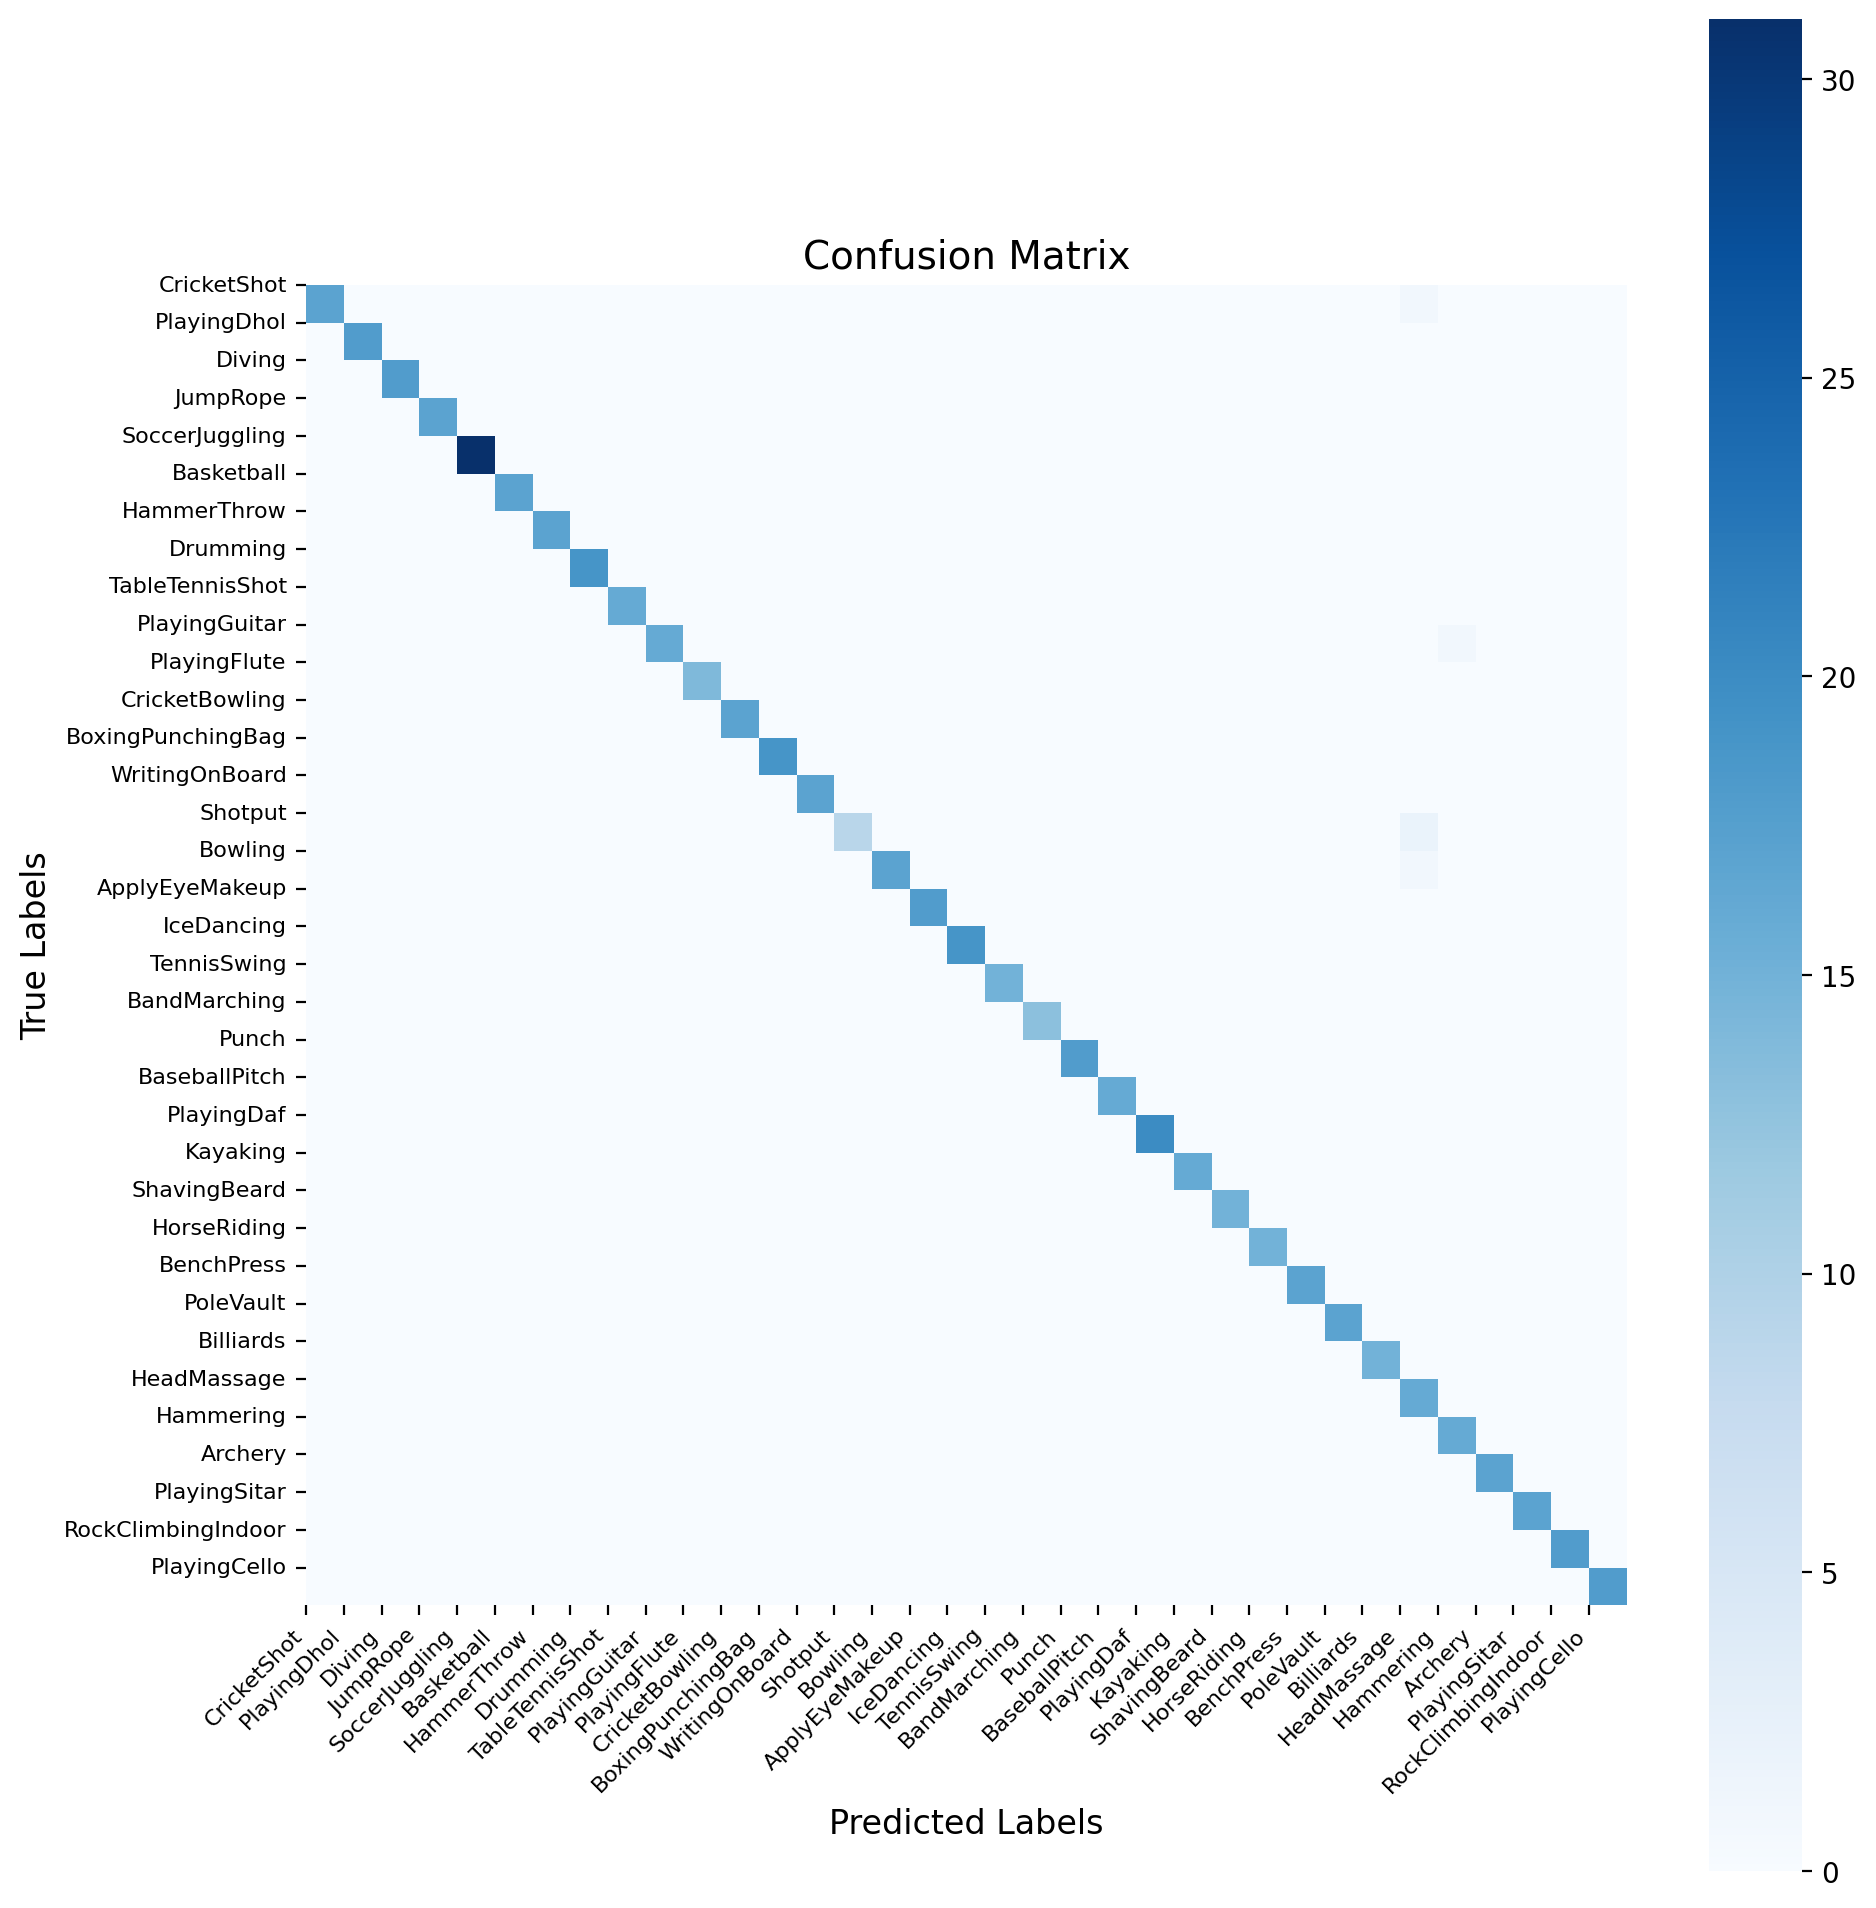

In [37]:
evaluator = Evaluator()

evaluator.plot_confusion_matrix(y_true, y_pred)